# A primer on Bayesian analysis

I designed this notebook to give you a primer on Bayesian analysis: how it works, why you should use it, and how it can change your results. To run Bayesian analysis on your own data, check out the file named `bayes.ipynb` in this folder.

First, when should you use Bayesian analysis? You should use Bayesian analysis when comparing 4 or more "things." For example, you should you Bayesian analysis when you run a study comparing the effects of 4 or more treatments or when studying differences among 4 or more groups of people. (The reason we start at 4 instead of 3 or 5 has to do with the [mathematical underpinnings](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of Bayesian estimators.)

Throughout this notebook, I'll illustrate the importance of Bayesian estimators with an example from [A megastudy of text-based nudges encouraging patients to get vaccinated at an upcoming doctor's appointment](https://www.pnas.org/content/118/20/e2101165118) published in PNAS. The authors partnered with Penn Medicine to send patients one of 19 text messages encouraging them to get a flu vaccine. Using OLS, the authors [reported that their top-performing text message increased vaccination rates by 11%](https://twitter.com/katy_milkman/status/1362579547401687040) (or 4.6 percentage points). Many popular media outlets, including the [Economist](https://www.economist.com/by-invitation/2020/11/30/katy-milkman-on-how-to-nudge-people-to-accept-a-covid-19-vaccine), the [Washington Post](https://www.washingtonpost.com/outlook/2021/05/24/nudges-vaccination-psychology-messaging/), [CNBC](https://www.cnbc.com/2021/06/26/return-to-office-and-vaccines-how-companies-can-drum-up-enthusiasm.html), [NPR](https://www.npr.org/2021/05/26/1000616898/the-science-behind-vaccine-incentives), and [CNN](https://kyma.com/cnn-health/2021/06/29/this-simple-text-message-can-encourage-people-to-get-vaccinated-researchers-say/), point to this research as a remarkable example of how behavioral economics can encourage people to get vaccinated and potentially save lives during the COVID-19 pandemic. As [Fortune](https://fortune.com/2021/02/20/covid-vaccine-rollout-getting-people-vaccinated-vaccination-rates-behavioral-nudge-wharto/) reported,

> What they found was eye-opening. Precisely *how* a message was worded had a huge impact on whether the patient ended up getting the shot.

Researchers continue to speculate about why the top-performing message was so much more successful than the others.

We'll start by reconstructing this dataset. We know that there were 47,306 participants evenly assigned to one of 19 treatments or a control condition. The outcome was binary (did the patient get a vaccine or not), and we know the vaccination rate in each treatment from the PNAS publication. Don't worry about following the code. The important point is that we can reproduce the original dataset with a high degree of accuracy.

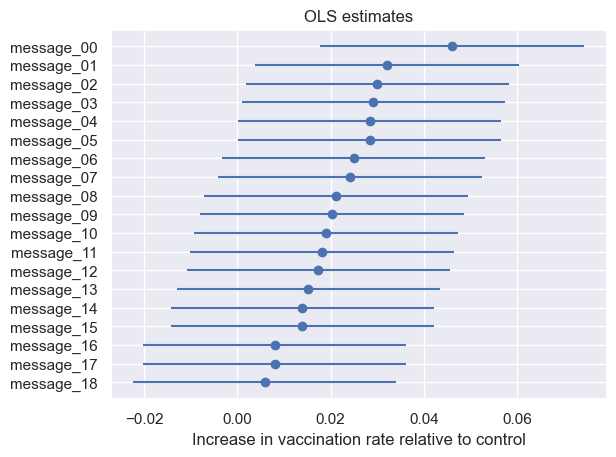

In [1]:
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.bayes.empirical import LinearEmpiricalBayes, JamesStein
from conditional_inference.bayes.hierarchical import LinearHierarchicalBayes

N_PATIENTS = 47306
VACCINATION_RATES = [
    .466,  # top-ranked treatment
    .452,
    .450,
    .449,
    .448,
    .448,
    .445,
    .444,
    .441,
    .440,
    .439,
    .438,
    .437,
    .435,
    .434,
    .434,
    .428,
    .428,
    .426,
    .420,  # control
]

np.random.seed(123)
sns.set()

# reconstruct the dataset
def generate_outcomes(vaccination_rate):
    # create a binary indicator of whether the patient got a vaccine
    n_vaccinations = round(vaccination_rate * n_participants_per_arm)
    return n_vaccinations * [1] + (n_participants_per_arm - n_vaccinations) * [0]

    
n_treatments = len(VACCINATION_RATES)
n_participants_per_arm = round(N_PATIENTS / n_treatments)
df = pd.DataFrame()
df["vaccinated"] = np.array([generate_outcomes(vaccination_rate) for vaccination_rate in VACCINATION_RATES]).flatten()
df["treatment"] = np.repeat([f"message_{format(i, '02')}" for i in range(n_treatments - 1)] + ["control"], n_participants_per_arm)

# perform OLS analysis
X = pd.get_dummies(df.drop(columns="vaccinated"), prefix="", prefix_sep="")
X["control"] = 1  # set the control arm as the constant regressor
results = sm.OLS(df.vaccinated, X).fit().get_robustcov_results()
treatment_coefficients = [col for col in X.columns if col != "control"]
# note that Bayesian analysis with an infinite prior is equivalent to OLS
ols_results = LinearClassicBayes.from_results(results, prior_cov=np.inf, cols=treatment_coefficients).fit()

# plot the OLS estimates
ols_results_plot = ols_results.point_plot(title="OLS estimates")
ols_results_plot.set_xlabel("Increase in vaccination rate relative to control")
plt.show()

## How does Bayesian analysis work?

In Bayesian analysis, we start with a prior belief. For example, we might expect that the treatments we're about to test will increase vaccination rates by 4 percentage points. Then we collect data and update our belief. [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) is a mathematical formula that tells us how much we should update our prior belief based the data. The updated belief is called a *posterior*.

A natural question to ask is, "Where does our prior belief come from?" This package implements 3 different versions of Bayesian analysis - classical, empirical, and hierarchical - and each version gives a different answer to this question.

Classical Bayes takes the prior as a given. For example, you might have a prior belief based on data from previous studies or a survey of subject matter experts.

I dislike this approach because I prefer to let my data speak for themselves. That's where empirical Bayes comes to the rescue. Empirical Bayes estimates a prior based on the data. This might sound like a contradiction. By definition, the prior is what you expect *before* seeing any data, so doesn't estimating a prior based on the data undermine what we're trying to do here?

To give some intuition for empirical Bayes, imagine we want to predict MLB players' on-base percentage (OBP) next season. For returning players, we might predict that next season's OBP will be the same as this season's OBP. But what do we predict for a rookie who has no batting history? One approach would be to predict that the rookie's OBP next season will be similar to the average rookie's OBP this season. In Bayesian terms, we've constructed a prior belief about the next season's rookies' OBP from data about this season's rookies' OBP.

We can apply the same logic to the flu study. Imagine we randomly select one text message and put the data for that treatment in a locked box. What should our prior belief about the effect of this text message be? Empirical Bayes says, roughly, that our prior belief about the effect of the message we locked in the box should be the average effect of the other 18. We can also use the variability in the effects of the other 18 messages to tell us how confident we should be in our prior, giving us a *prior distribution*.

Let's take a look at the prior we get from empirical Bayes.

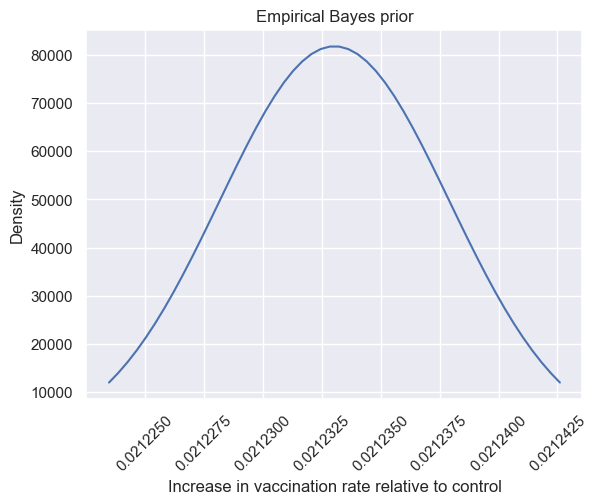

In [2]:
# estimate the prior distribution
empirical_bayes_model = LinearEmpiricalBayes.from_results(results, cols=treatment_coefficients)
prior_mean, prior_std = empirical_bayes_model.estimate_prior_params()
prior = norm(prior_mean, prior_std)

# plot the prior
x = np.linspace(prior.ppf(.025), prior.ppf(.975)).squeeze()
prior_plot = sns.lineplot(x=x, y=prior.pdf(x))
prior_plot.set_title("Empirical Bayes prior")
prior_plot.set_ylabel("Density")
prior_plot.set_xlabel("Increase in vaccination rate relative to control")
plt.xticks(rotation=45)
plt.show()

Look at the x-axis of the plot above. You'll see that the prior is extremely narrow. The narrow prior is a consequence of how the empirical Bayes model estimated it (by maximum likelihood). There are at least two ways to widen the prior distribution. One, which we'll see later, is to use a different version of empirical Bayes called the [*James-Stein estimator*](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator). Another is to use a [*hierarchical Bayesian model*](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling).

Hierarchical Bayes says to empirical Bayes, "anything you can do, I can do meta." Hierarchical Bayes adds another layer to the empirical Bayes model in which we have a prior belief about our prior belief. This "prior belief about the prior belief" is called a *hyperprior*. We can use the hyperprior to express uncertainty in our prior belief and widen the prior distribution.

We could estimate the hyperprior using cross-validation, but I'm not going to get into that here. Below, I estimate the hyperprior using a simple heuristic that I've found works well on many datasets. Again, don't worry about following the code. The key takeaway is that the prior distribution looks more reasonable.

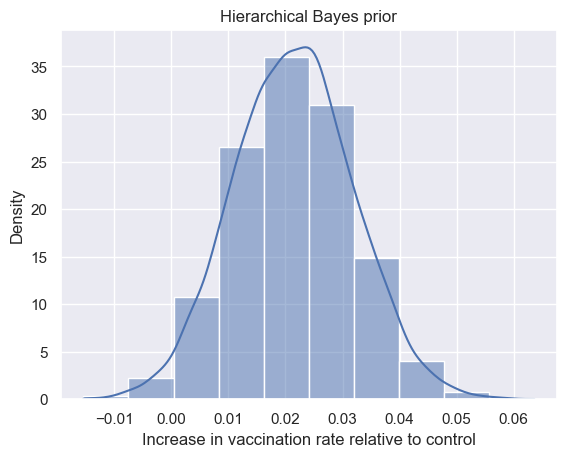

In [3]:
# estimate the hyperprior using a simple heuristic
hyperprior = loguniform(prior_std, 2 * prior_std)

# use Gibbs sampling to sample from the prior distribution
hierarchical_bayes_model = LinearHierarchicalBayes.from_results(results, cols=treatment_coefficients, prior_cov_params_distribution=hyperprior)
prior_cov_rvs, sample_weight = hierarchical_bayes_model.prior_cov_rvs(10000)
prior_mean_rvs = [hierarchical_bayes_model.prior_mean_rvs(prior_cov).mean() for prior_cov in prior_cov_rvs]

# plot the prior distribution
ax = sns.histplot(x=prior_mean_rvs, weights=sample_weight, kde=True, stat="density")
ax.set_title("Hierarchical Bayes prior")
ax.set_xlabel("Increase in vaccination rate relative to control")
plt.show()

### Summary

In Bayesian analysis, we begin with a prior belief about our treatment effects. We then use data to update our belief according to Bayes' theorem. Our updated belief is called the *posterior*.

The key to good Bayesian analysis is a good prior belief. Classical Bayes takes the prior as a given. Empirical Bayes estimates a prior belief from the data. However, depending on how you estimate it, you may end up being overconfident in your prior belief. To fix this, you can try a different empirical Bayes estimator, like James-Stein, or express uncertainty in your prior belief using a hierarchical Bayesian estimator.

## Why should I use Bayesian analysis?

Why use this fancy, complicated Bayesian analysis when you can use standard techniques like OLS? The short answer is that Bayesian estimators make better predictions of the true treatment effects than OLS. I'm going to give you three ways to verify this claim using mathematical proofs, out-of-sample testing, and reconstruction plots. 

First, let's look at the math. James and Stein (1961) proved that their empirical Bayes estimator *dominates* unbiased estimators like OLS. This means that the James-Stein estimator has a lower expected mean squared error than OLS no matter what the true treatment effects are.

We can also mathematically show that, under standard assumptions, unbiased estimators like OLS exaggerate the variability of treatment effects. This fictitious variation makes it seem as though the best treatment is much better than average, and the worst treatment much worse than average, than it actually is. [Bayesian estimates "shrink" OLS estimates](https://kiwidamien.github.io/shrinkage-and-empirical-bayes-to-improve-inference.html), meaning that the posterior belief always falls between the OLS estimate and the prior. In shrinking the OLS estimates, Bayesian estimators reduce and often eliminate fictitious variation.

A second way to verify that Bayesian estimators make better predictions than OLS is to use [*out-of-sample testing*](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). To understand out-of-sample testing, imagine we decide to run our experiment twice. After the first experiment, we get both Bayesian and OLS estimates. Then, we use these estimates to predict what's going to happen in the second experiment. After running the second experiment, we can see which estimator was better.

We may not be able to rerun our experiment, but we can simulate this process by splitting our data in half. We'll use one half of the data (called the *training set* or *in-sample data*) to train our models and get Bayesian and OLS estimates. Then, we test how well these estimates matched the other half of the data (called the *test set* or *out-of-sample data*).

Below, we repeat this splitting procedure many times and see how two Bayesian estimators, the James-Stein estimator and the hierarchical Bayes estimator, stack up against OLS.

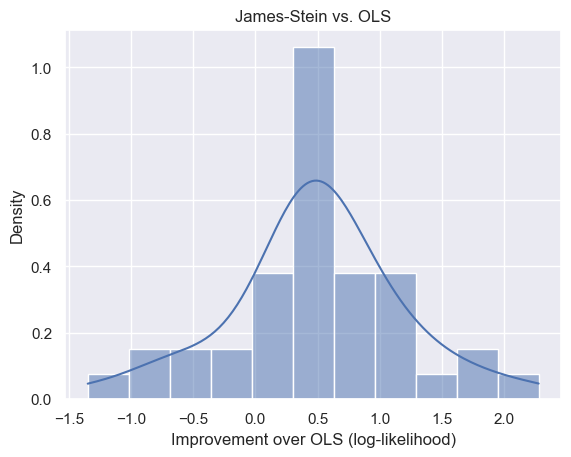

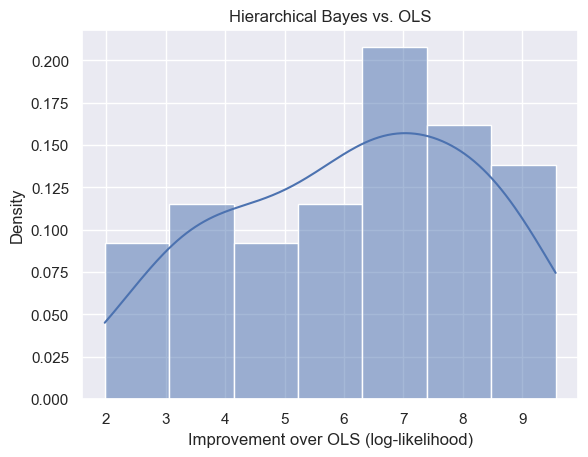

In [4]:
def estimate_mean_and_covariance(index):
    # estimate the OLS means (point estimates) and covariance matrix
    X_subset, y_subset = X.iloc[index], df.vaccinated.iloc[index]
    results = sm.OLS(y_subset, X_subset).fit().get_robustcov_results()
    treatment_coefficients = [i for i, coefficient in enumerate(results.model.exog_names) if coefficient != "control"]
    return (
        results.params[treatment_coefficients],
        results.cov_params()[treatment_coefficients][:, treatment_coefficients]
    )


def compute_test_likelihood(train_mean, train_cov, test_mean, test_cov, model_cls, **init_kwargs):
    # train the model on the training data
    # then ask it to predict how likely we would be to observe the test data
    results = model_cls(train_mean, train_cov, **init_kwargs).fit()
    return results.likelihood(test_mean, test_cov)


def plot_improvement(bayes_test_likelihood, title):
    # plot how much the Bayesian model's test log likelihood improved upon OLS's test log likelihood
    improvement = np.log(bayes_test_likelihood) - np.log(ols_test_likelihood)
    ax = sns.histplot(x=improvement, kde=True, stat="density")
    ax.set_title(title)
    ax.set_xlabel("Improvement over OLS (log-likelihood)")
    return ax


ols_test_likelihood = []
jamesstein_test_likelihood = []
hierarchical_bayes_test_likelihood = []
kf = RepeatedStratifiedKFold(n_splits=2, n_repeats=20)

for train_index, test_index in kf.split(df, df.treatment):
    train_mean, train_cov = estimate_mean_and_covariance(train_index)
    test_mean, test_cov = estimate_mean_and_covariance(test_index)

    ols_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, LinearClassicBayes, prior_cov=np.inf
        )
    )

    jamesstein_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, JamesStein
        )
    )

    _, prior_std = LinearEmpiricalBayes(train_mean, train_cov).estimate_prior_params()
    hyperprior = loguniform(prior_std, 2 * prior_std)
    hierarchical_bayes_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, LinearHierarchicalBayes, prior_cov_params_distribution=hyperprior
        )
    )

plot_improvement(jamesstein_test_likelihood, "James-Stein vs. OLS")
plt.show()

plot_improvement(hierarchical_bayes_test_likelihood, "Hierarchical Bayes vs. OLS")
plt.show()

Our out-of-sample analysis points to two conclusions:

1. Both Bayesian estimators consistently make better predictions about the test set than OLS.
2. The hierarchical Bayesian estimator makes even better predictions than James-Stein.

The third way to verify that Bayesian estimators are better than OLS is to look at reconstruction plots. I find this to be the most intuitive demonstration that Bayesian estimators are superior, although out-of-sample testing is more rigorous.

Reconstruction plots answer the following question: If these estimates are correct and we reran our experiment, how similar would the distribution of estimates in the second experiment be to the distribution of estimates in the original experiment? Ideally, the distribution of estimates we would expect to see if we reran the experiment should match the distribution of estimates we saw in the original.

Below are reconstruction plots for the OLS, James-Stein, and hierarchical Bayes estimators. The original estimates are the orange x's. The distribution of estimates we would expect is in blue.


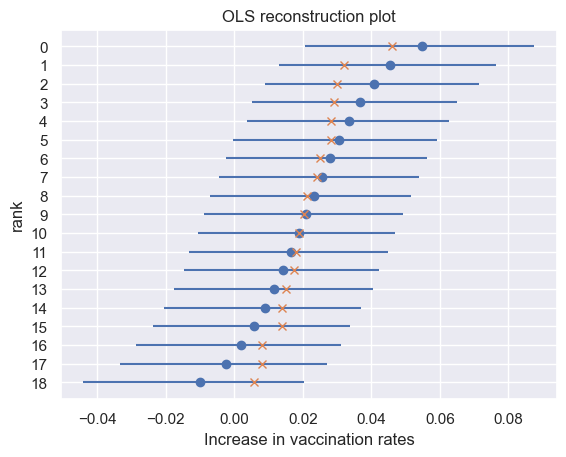

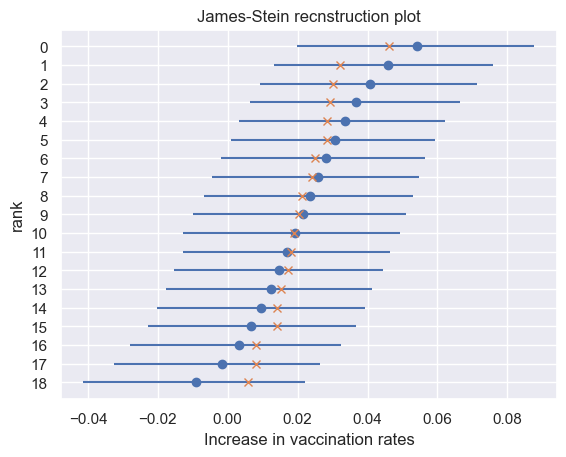

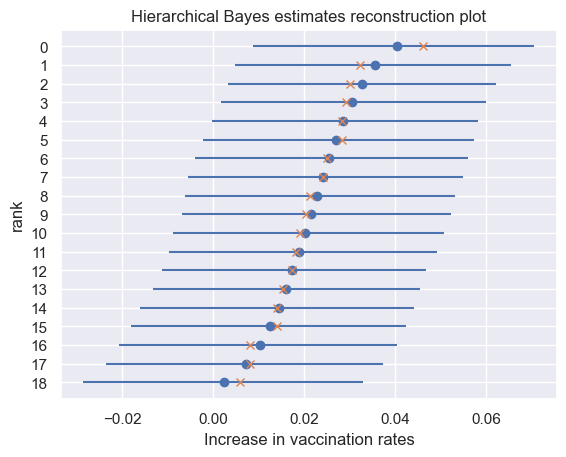

In [5]:
def make_reconstruction_plot(results, title=None):
    ax = results.reconstruction_point_plot(title=title)
    ax.set_xlabel("Increase in vaccination rates")
    return ax

make_reconstruction_plot(ols_results, "OLS reconstruction plot")
plt.show()

jamesstein_results = JamesStein.from_results(results, cols=treatment_coefficients).fit()
make_reconstruction_plot(jamesstein_results, "James-Stein recnstruction plot")
plt.show()

hierarchical_results = hierarchical_bayes_model.fit()
make_reconstruction_plot(hierarchical_results)
plt.show()

The reconstruction plots confirm our out-of-sample testing.

1. OLS exaggerates the variability of treatment effects. If the OLS estimates were correct, we would have likely seen more dispersed treatment effect estimates in our original data.
2. James-Stein improves upon OLS, but the hierarchical Bayes model is the clear winner.

### Summary

Bayesian analysis is better than traditional techniques like OLS because it makes more accurate predictions of the true treatment effects. We verified this using mathematical proofs, out-of-sample testing, and reconstruction plots. For our flu study dataset, the hierarchical Bayes model is the clear winner.

## How much can Bayesian analysis change my results?

Maybe you're thinking, "Okay, I'm convinced that Bayesian models are better than OLS, but how different are they? Maybe they'll shrink the OLS estimates a little bit but is the difference that significant? Can Bayesian estimators fundamentally change our understanding of scientific research?"

To understand the impact of Bayesian analysis, let's see how OLS and Bayesian estimates compare for our flu study. As a reminder, the common perception of this study's results, both in popular media and in academic circles, is that the ability of a text to increase vaccination rates critically depends on its phrasing. This perception is best summed up by Fortune.

> What they found was eye-opening. Precisely *how* a message was worded had a huge impact on whether the patient ended up getting the shot.

There are two questions we can answer here:

1. How much do the true effects of the messages vary depending on the phrasing?
2. Can we identify which messages performed better than others and by how much?

These are related but distinct questions. For example, we know *that* some children will grow up to be much better at sports than others but we can't be sure *which* children will be better at sports when they're very young. In the same way, knowing *that* some messages work better than others is not the same as knowing *which* messages work better than others.
Let's start answering these questions by plotting the OLS and Bayesian estimates of the effects.

Remember that we've verified that the hierarchial Bayes model consistently and substantially outperformed OLS both in the reconstruction plot and in out-of-sample testing.

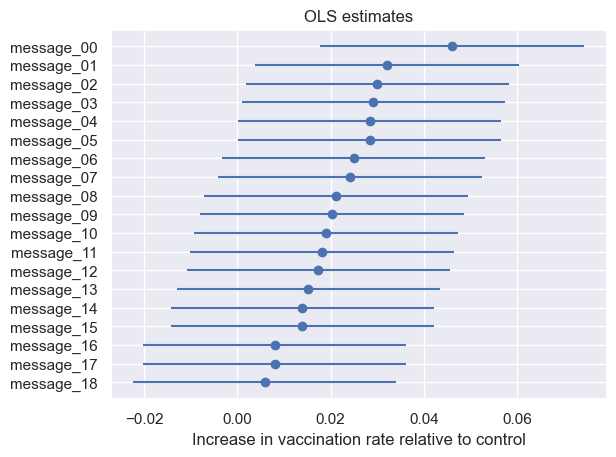

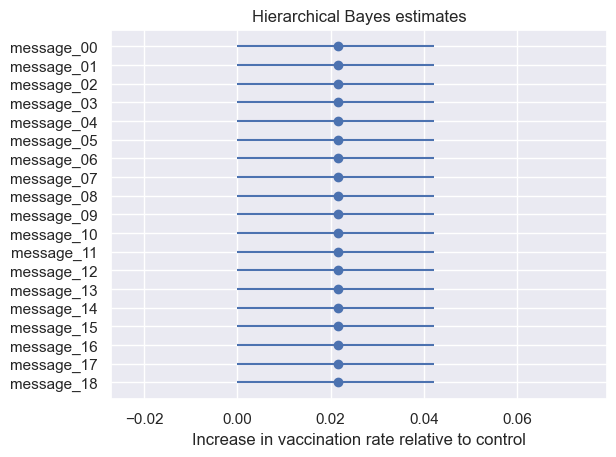

In [6]:
ols_ax = ols_results.point_plot(title="OLS estimates")
ols_ax.set_xlabel("Increase in vaccination rate relative to control")
plt.show()

hierarchical_ax = hierarchical_results.point_plot()
hierarchical_ax.set_xlim(ols_ax.get_xlim())
hierarchical_ax.set_xlabel("Increase in vaccination rate relative to control")
plt.show()

Looking at the OLS plot, we get the impression that we've identified certain text messages that outperform others. The Bayesian plot shows us that this perception is incorrect. According to the Bayesian model, we have almost no idea which messages are better than others.

Let's dig into this by looking at "relative effects," specifically

1. How much better is the best message than the average message?
2. How much better is the best message than the worst message?

We'll start with the messages that performed best and worst in the experiment (the *in-sample* best and worst messages). Remember, the messages that performed best and worst in the experiment may not truly be the best and worst messages. So this analysis answers our second question: Can we identify which messages performed better than others and by how much?

In [7]:
def estimate_relative_effects(header, params):
    print(20*"=", f"\n{header}")
    print(f"Increase in vaccination rates using the in-sample best treatment versus the average treatment: {100 * (params.max() - params.mean()):.4f} percentage points")
    print(f"Increase in vaccination rates using the in-sample best treatment versus the in-sample worst treatment: {100 * (params.max() - params.min()):.4f} percentage points")


estimate_relative_effects("Relative effects as estimated by OLS", ols_results.params)
estimate_relative_effects("Relative effects as estimated by hierarchical Bayes", hierarchical_results.params)

Relative effects as estimated by OLS
Increase in vaccination rates using the in-sample best treatment versus the average treatment: 2.4814 percentage points
Increase in vaccination rates using the in-sample best treatment versus the in-sample worst treatment: 4.0169 percentage points
Relative effects as estimated by hierarchical Bayes
Increase in vaccination rates using the in-sample best treatment versus the average treatment: 0.0000 percentage points
Increase in vaccination rates using the in-sample best treatment versus the in-sample worst treatment: 0.0001 percentage points


These results confirm what we saw in the point plots. OLS suggests that the in-sample best message is more than twice as effective as the average message. Our Bayesian model shows us that this is incorrect. The  effect of the in-sample best message is almost indistinguishable from the effects of the average and in-sample worst messages.

But, as we said, just because we can't identify which text messages perform better than others doesn't mean that phrasing doesn't matter. This brings us to our first question: How much do the true effects of the text messages vary depending on the phrasing?

To answer this question, we'll draw samples from the posterior distribution and look at the effect of the truly best message (i.e., the message that performed best in each draw) relative to the average and truly worst messages.

In [8]:
def estimate_relative_effects(header, posterior_mean_rvs):
    best_effect = posterior_mean_rvs.max(axis=1).mean()
    worst_effect = posterior_mean_rvs.min(axis=1).mean()
    average_effect = posterior_mean_rvs.mean()

    print(20*"=", f"\n{header}")
    print(f"Increase in vaccination rates using the truly best treatment versus the average treatment: {100 * float(best_effect - average_effect):.4f} percentage points")
    print(f"Increase in vaccination rates using the truly best treatment versus the truly worst treatment: {100 * float(best_effect - worst_effect):.4f} percentage points")


estimate_relative_effects("Relative effects as estimated by OLS", ols_results.posterior_mean_rvs)
estimate_relative_effects("Relative effects as estimated by hierarchical Bayes", hierarchical_results.posterior_mean_rvs)

Relative effects as estimated by OLS
Increase in vaccination rates using the truly best treatment versus the average treatment: 2.8038 percentage points
Increase in vaccination rates using the truly best treatment versus the truly worst treatment: 5.2787 percentage points
Relative effects as estimated by hierarchical Bayes
Increase in vaccination rates using the truly best treatment versus the average treatment: 0.0013 percentage points
Increase in vaccination rates using the truly best treatment versus the truly worst treatment: 0.0026 percentage points


Again, according to OLS, the phrasing matters tremendously. The Bayesian model shows us that this conclusion is also incorrect. While the average text message increases vaccination rates by 2.1 points, the marginal benefit of the truly best message is just 0.001 points.

## Conclusion

Bayesian analysis can significantly change our understanding of scientific research. We illustrated this by re-analyzing data from a highly-regarded study. Using Bayesian analysis, we showed that the study's original conclusion vastly overstated the effect of the best treatment compared to the average and worst treatments. Our analysis was quick and dirty and we didn't use the original data, so we shouldn't put too much stock in the precise numbers. However, it seems likely that the study's original analysis inflated the relative treatment effects by an order of magnitude or more.

Congratulations for sticking with this primer until the end! We've explained how Bayesian analysis works, why you should use it, and how it can impact your results. To run Bayesian analysis on your own data, check out the file named `bayes.ipynb` in this folder.